In [1]:
# import
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np 
from utils import *
from ADMM import *

# 1 Load data

1. prediction: `x = data[0:24], y = data[0:12]`
2. difference: `dx[t] = x[t+1] - x[t]`
3. interpolation: `x = data[0:24], y = x * mask`. Mask rate 0.4, set to `NaN`

In [2]:
# dataset
data_dir = '../datasets/PEMS0X_data'
# TODO: change here
dataset = 'PEMS04'
data_folder = os.path.join(data_dir, dataset)
data_file = dataset + '.npz'
graph_csv = dataset + '.csv'
# data
traffic_dataset = TrafficDataset(data_folder, data_file, graph_csv)
print(f"data shape: {traffic_dataset.data.shape}, node number: {traffic_dataset.graph_info['n_nodes']}, edge number: {traffic_dataset.graph_info['n_edges']}")

# kNNs and graph construction
k = 4
nearest_nodes, nearest_dists = k_nearest_neighbors(traffic_dataset.graph_info['n_nodes'], traffic_dataset.graph_info['u_edges'], traffic_dataset.graph_info['u_dist'], k)
print(f'nearest nodes: {nearest_nodes.shape}, nearest_dists: {nearest_dists.shape}')

# mixed_graph_from_distance()

x, y = traffic_dataset.get_predict_data(0)
x, y = x.unsqueeze(0), y.unsqueeze(0)
print(f'recovering: x: {x.shape}, y: {y.shape}')

# difference in data
diff_x, diff_y = get_data_difference(x), get_data_difference(y)
print(f'difference: x: {diff_x.shape}, y: {diff_y.shape}')

# interpolation
interp_x, interp_y, mask = traffic_dataset.get_interpolated_data(0, 0.4)
interp_x, interp_y, mask = interp_x.unsqueeze(0), interp_y.unsqueeze(0), mask.unsqueeze(0)
print(f'interpolation: x: {interp_x.shape}, y: {interp_y.shape}, mask: {mask.shape}')

data shape: torch.Size([16992, 307, 1]), node number: 307, edge number: 340
307 nodes, 4 neighbors
nearest nodes: torch.Size([307, 5]), nearest_dists: torch.Size([307, 5])
recovering: x: torch.Size([1, 24, 307, 1]), y: torch.Size([1, 12, 307, 1])
difference: x: torch.Size([1, 23, 307, 1]), y: torch.Size([1, 11, 307, 1])
interpolation: x: torch.Size([1, 24, 307, 1]), y: torch.Size([1, 24, 307, 1]), mask: torch.Size([1, 24, 307, 1])


# 2 Regression

Test regression result for neighbor of one node
- prediction
- difference
- interpolation

torch.Size([1, 24, 5, 1])


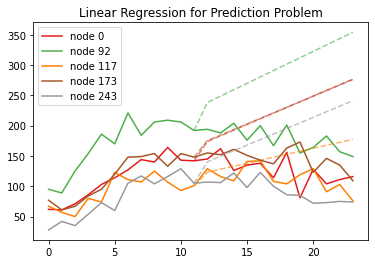

Linear regression: w torch.Size([1, 5, 1]), b torch.Size([1, 5, 1])
torch.Size([1, 24, 5, 1])


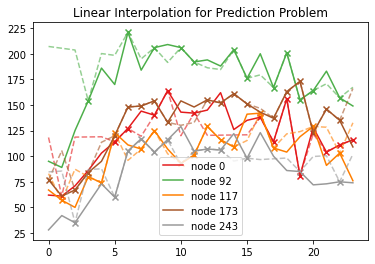

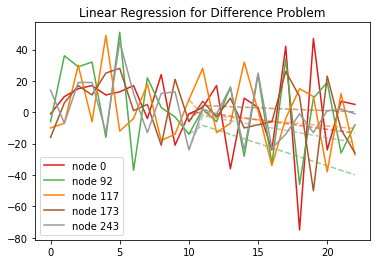

torch.Size([1, 24, 5, 1])


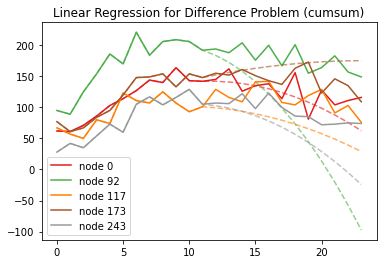

In [3]:
# take node 0 as an example
knn = nearest_nodes[0].to(torch.long) # [0. 92, 117, 173, 243]
# prediction
x_data = x[:,:,knn]
y_data = y[:,:,knn]
diff_x_data = diff_x[:,:,knn]
diff_y_data = diff_y[:,:,knn]
interp_x_data = interp_x[:,:,knn]
interp_y_data = interp_y[:,:,knn]
mask_data = mask[:,:,knn]

# linear regression
lr_y = initial_guess(y_data, 12, 24)
print(lr_y.shape)
t = torch.arange(0, 24, 1)
colors = plt.cm.Set1(np.linspace(0, 1, 5))

plt.figure()
for i, color in enumerate(colors):
    plt.plot(t, x_data.squeeze()[:,i], color=color, label=f'node {knn[i]}')
    plt.plot(t[11:], lr_y.squeeze()[11:,i], color=color, linestyle='--', alpha=0.6)
# plt.legend([f'node {i}' for i in knn])
plt.legend()
plt.title('Linear Regression for Prediction Problem')
plt.show()

# interpolation
lr_interp_y = initial_interpolation(interp_y_data, mask_data)
print(lr_interp_y.shape)
plt.figure()
for i, color in enumerate(colors):
    plt.plot(t, x_data.squeeze()[:,i], color=color, label=f'node {knn[i]}')
    plt.plot(t, lr_interp_y.squeeze()[:,i], color=color, linestyle='--', alpha=0.6)
    mask_i = mask_data.squeeze()[:,i].bool()

    # x_mask_i = x_data.squeeze()[mask.squeeze()[:,i] == 1, i]
    plt.scatter(t[mask_i], x_data.squeeze()[:,i][mask_i], color=color, marker='x')
# plt.legend([f'node {i}' for i in knn])
plt.legend()
plt.title('Linear Interpolation for Prediction Problem')
plt.show()

# difference
lr_diff_y = initial_guess(diff_y_data, 11, 23)
# t = torch.arange(0, 23, 1)
plt.figure()
for i, color in enumerate(colors):
    # plt.plot(t, x_data.squeeze()[:,i], color=color, label=f'node {knn[i]}')
    # plt.plot(t[11:], cumsum_y.squeeze()[11:,i], color=color, linestyle='--', alpha=0.6)
    plt.plot(t[:-1], diff_x_data.squeeze()[:,i], color=color, label=f'node {knn[i]}')
    plt.plot(t[10:-1], lr_diff_y.squeeze()[10:,i], color=color, linestyle='--', alpha=0.6)

plt.legend()
plt.title('Linear Regression for Difference Problem')
plt.show()

plt.figure()

# sum up
cumsum_y = torch.cumsum(lr_diff_y, dim=1) + y_data[:,:1]
cumsum_y = torch.cat((y_data[:,0:1], cumsum_y), dim=1)
print(cumsum_y.shape)
for i, color in enumerate(colors):
    # plt.plot(t, x_data.squeeze()[:,i], color=color, label=f'node {knn[i]}')
    # plt.plot(t[11:], cumsum_y.squeeze()[11:,i], color=color, linestyle='--', alpha=0.6)
    plt.plot(t, x_data.squeeze()[:,i], color=color, label=f'node {knn[i]}')
    plt.plot(t, cumsum_y.squeeze()[:,i], color=color, linestyle='--', alpha=0.6)

plt.legend()
plt.title('Linear Regression for Difference Problem (cumsum)')
plt.show()


# 3 ADMM algorithm

different graph types:
- undirected graph: kNN graph based on distance on each layer
- directed graphs:
    - kNN graphs
    - line graphs

different data types:
- prediction
- interpolation
- difference

ablation studies:
- w/o DGTV
- w/o DGLR
- fully undirected graph

## 3.1 Prediction problems
- with directed graph as kNN graph
- directed graph as line graph

rho_init: 3.5765439556458225
307 nodes, 4 neighbors
Undirected graph: sigma = 50, nearest_dist in (3.2000, 2895.6001)
Directed Graph: sigma = 50, nearest_dist in (3.2000, 2895.6001)
u_ew, d_ew shape torch.Size([24, 307, 4]) torch.Size([23, 307, 5])
ADMM iters 0: x_CG_iters 14, zu_CG_iters 11, zd_CG_iters 16, pri_err = [1696, 23.77, 371.1], dual_err = [1696, 23.76, 371.1]
ADMM iters 1: x_CG_iters 20, zu_CG_iters 11, zd_CG_iters 16, pri_err = [71.06, 7.413, 78.64], dual_err = [276.7, 444.6, 1955]
ADMM iters 2: x_CG_iters 19, zu_CG_iters 11, zd_CG_iters 15, pri_err = [205.2, 6.469, 30.17], dual_err = [763.6, 218.2, 890.5]
ADMM iters 3: x_CG_iters 19, zu_CG_iters 11, zd_CG_iters 16, pri_err = [187.4, 5.224, 40.53], dual_err = [706.4, 162.1, 690.7]
ADMM iters 4: x_CG_iters 19, zu_CG_iters 11, zd_CG_iters 16, pri_err = [157.9, 5.401, 43.33], dual_err = [614.6, 128.9, 590.6]
ADMM iters 5: x_CG_iters 19, zu_CG_iters 11, zd_CG_iters 15, pri_err = [132.1, 5.337, 40.05], dual_err = [534.2, 105, 5

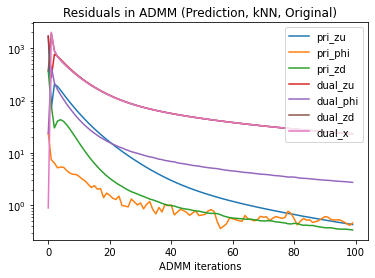

c:\Users\qij21\Desktop\test\ADMM-demo\ADMM.py:528: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:210.)
  dxps = torch.tensor([item.cpu().detach().numpy() for item in self.delta_x_per_step]) # in (L, 24)


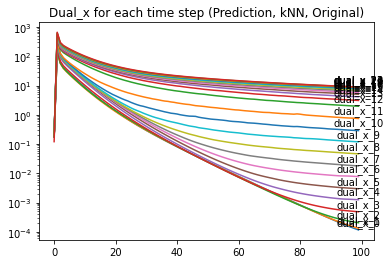

In [4]:
import math
rho_init = math.sqrt(traffic_dataset.graph_info['n_nodes'] / 24)
mu_init = 1
print('rho_init:', rho_init)
ADMM_info = {
    'rho': rho_init * 2,
    'rho_u': rho_init * 3,
    'rho_d': rho_init * 2,
    'mu_u': mu_init,
    'mu_d1':mu_init * 2,
    'mu_d2': mu_init
}
admm_block = ADMM_algorithm(traffic_dataset.graph_info,
                            ADMM_info,
                            use_kNN=True,
                            k=4,
                            u_sigma=50,
                            d_sigma=50,
                            )
x_pred = admm_block.combined_loop(y)
admm_block.plot_residual(descriptions='Prediction, kNN, Original', log_y=True)
admm_block.plot_x_per_step(descriptions='Prediction, kNN, Original', log_y=True)

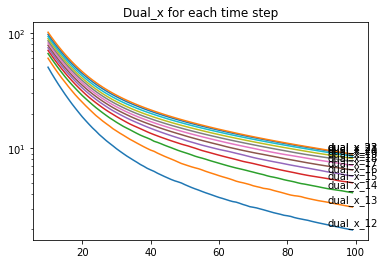

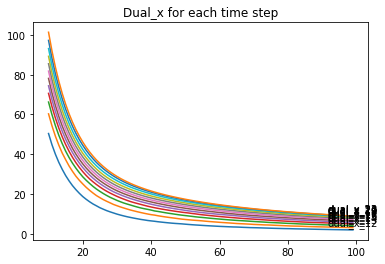

In [5]:
admm_block.plot_x_per_step(show_list=range(12, 24), start_iters=10, log_y=True)
admm_block.plot_x_per_step(show_list=range(12, 24), start_iters=10, log_y=False)
# admm_block.plot_CG_params()

rho_init: 3.5765439556458225
307 nodes, 4 neighbors
Undirected graph: sigma = 50, nearest_dist in (3.2000, 2895.6001)
u_ew, d_ew shape torch.Size([24, 307, 4]) torch.Size([23, 307, 1])
ADMM iters 0: x_CG_iters 14, zu_CG_iters 11, zd_CG_iters 16, pri_err = [1696, 23.75, 345.9], dual_err = [1696, 23.74, 345.9]
ADMM iters 1: x_CG_iters 19, zu_CG_iters 11, zd_CG_iters 16, pri_err = [67.83, 6.92, 75.88], dual_err = [269.2, 335.4, 1982]
ADMM iters 2: x_CG_iters 19, zu_CG_iters 11, zd_CG_iters 15, pri_err = [205.5, 5.905, 22.44], dual_err = [764, 185.3, 890.2]
ADMM iters 3: x_CG_iters 18, zu_CG_iters 11, zd_CG_iters 15, pri_err = [187.6, 5.17, 38.1], dual_err = [706.7, 138.2, 689.7]
ADMM iters 4: x_CG_iters 18, zu_CG_iters 11, zd_CG_iters 15, pri_err = [158, 5.052, 42.36], dual_err = [614.8, 109.6, 590.1]
ADMM iters 5: x_CG_iters 18, zu_CG_iters 11, zd_CG_iters 15, pri_err = [132.2, 4.887, 39.55], dual_err = [534.4, 88.8, 513.9]
ADMM iters 6: x_CG_iters 18, zu_CG_iters 11, zd_CG_iters 15, pri

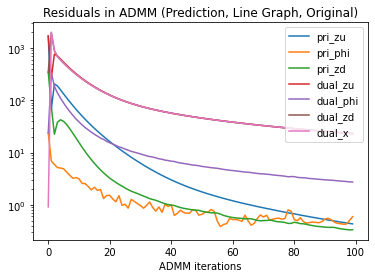

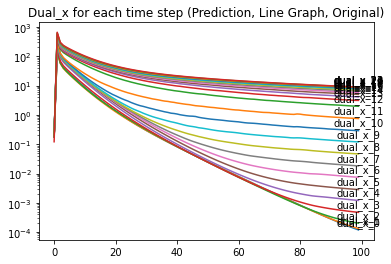

In [6]:
import math
rho_init = math.sqrt(traffic_dataset.graph_info['n_nodes'] / 24)
mu_init = 1
print('rho_init:', rho_init)
ADMM_info = {
    'rho': rho_init * 2,
    'rho_u': rho_init * 3,
    'rho_d': rho_init * 2,
    'mu_u': mu_init,
    'mu_d1':mu_init * 2,
    'mu_d2': mu_init
}
admm_block = ADMM_algorithm(traffic_dataset.graph_info,
                            ADMM_info,
                            use_kNN=True,
                            k=4,
                            u_sigma=50,
                            d_sigma=50,
                            use_line_graph=True
                            )
x_pred = admm_block.combined_loop(y)
admm_block.plot_residual(descriptions='Prediction, Line Graph, Original', log_y=True)
admm_block.plot_x_per_step(descriptions='Prediction, Line Graph, Original', log_y=True)
# admm_block.plot_CG_params()

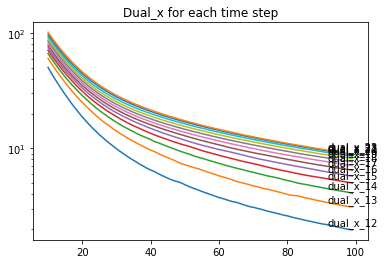

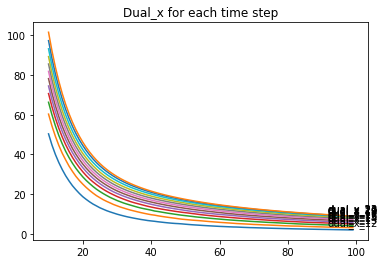

In [7]:
admm_block.plot_x_per_step(show_list=range(12, 24), start_iters=10, log_y=True)
admm_block.plot_x_per_step(show_list=range(12, 24), start_iters=10, log_y=False)

## 3.2 Interpolation Problems
- directed graphs as kNN graphs
- directed graphs as line graphs

rho_init: 3.5765439556458225
307 nodes, 4 neighbors
Undirected graph: sigma = 50, nearest_dist in (3.2000, 2895.6001)
Directed Graph: sigma = 50, nearest_dist in (3.2000, 2895.6001)
u_ew, d_ew shape torch.Size([24, 307, 4]) torch.Size([23, 307, 5])
Linear regression: w torch.Size([1, 307, 1]), b torch.Size([1, 307, 1])
ADMM iters 0: x_CG_iters 20, zu_CG_iters 11, zd_CG_iters 17, pri_err = [1213, 23.34, 598.1], dual_err = [1294, 454.6, 921.6]
ADMM iters 1: x_CG_iters 20, zu_CG_iters 11, zd_CG_iters 16, pri_err = [83.2, 13.24, 191], dual_err = [664.7, 630, 1370]
ADMM iters 2: x_CG_iters 20, zu_CG_iters 11, zd_CG_iters 16, pri_err = [131.9, 10.94, 120], dual_err = [723.7, 397.8, 763.9]
ADMM iters 3: x_CG_iters 20, zu_CG_iters 11, zd_CG_iters 16, pri_err = [115.7, 9.608, 114.6], dual_err = [668.6, 312.6, 657.1]
ADMM iters 4: x_CG_iters 20, zu_CG_iters 11, zd_CG_iters 16, pri_err = [93.94, 9.229, 107], dual_err = [610.3, 256, 601.1]
ADMM iters 5: x_CG_iters 19, zu_CG_iters 11, zd_CG_iters 1

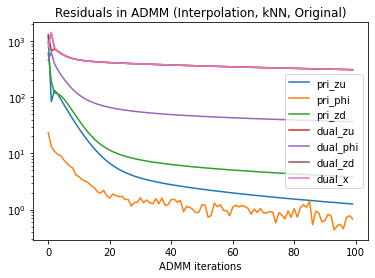

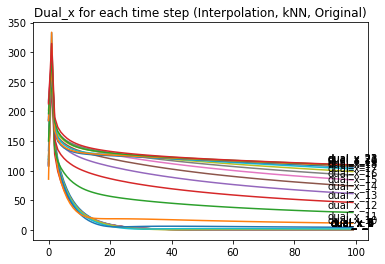

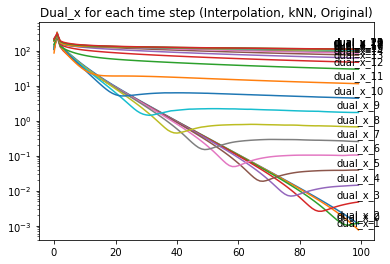

In [8]:
import math
rho_init = math.sqrt(traffic_dataset.graph_info['n_nodes'] / 24)
mu_init = 1
print('rho_init:', rho_init)
ADMM_info = {
    'rho': rho_init * 2,
    'rho_u': rho_init * 3,
    'rho_d': rho_init * 2,
    'mu_u': mu_init,
    'mu_d1':mu_init * 2,
    'mu_d2': mu_init
}
admm_block = ADMM_algorithm(traffic_dataset.graph_info,
                            ADMM_info,
                            use_kNN=True,
                            k=4,
                            u_sigma=50,
                            d_sigma=50,
                            )
x_interp = admm_block.combined_loop(interp_y, mask=mask)
admm_block.plot_residual(descriptions='Interpolation, kNN, Original', log_y=True)
admm_block.plot_x_per_step(descriptions='Interpolation, kNN, Original', log_y=False)
admm_block.plot_x_per_step(descriptions='Interpolation, kNN, Original', log_y=True)

rho_init: 3.5765439556458225
307 nodes, 4 neighbors
Undirected graph: sigma = 50, nearest_dist in (3.2000, 2895.6001)
u_ew, d_ew shape torch.Size([24, 307, 4]) torch.Size([23, 307, 1])
Linear regression: w torch.Size([1, 307, 1]), b torch.Size([1, 307, 1])
ADMM iters 0: x_CG_iters 19, zu_CG_iters 11, zd_CG_iters 17, pri_err = [1213, 23.34, 597.2], dual_err = [1293, 453, 925.5]
ADMM iters 1: x_CG_iters 20, zu_CG_iters 11, zd_CG_iters 16, pri_err = [82.58, 13.34, 193.4], dual_err = [663.9, 606.1, 1386]
ADMM iters 2: x_CG_iters 19, zu_CG_iters 11, zd_CG_iters 16, pri_err = [131.7, 11.07, 120], dual_err = [723.5, 396.6, 762.9]
ADMM iters 3: x_CG_iters 19, zu_CG_iters 11, zd_CG_iters 16, pri_err = [115.6, 9.848, 115.6], dual_err = [668.5, 311.9, 656.1]
ADMM iters 4: x_CG_iters 19, zu_CG_iters 11, zd_CG_iters 16, pri_err = [93.84, 9.229, 108.6], dual_err = [610.1, 255.1, 600.6]
ADMM iters 5: x_CG_iters 19, zu_CG_iters 11, zd_CG_iters 16, pri_err = [75.59, 7.204, 95.93], dual_err = [565, 213.

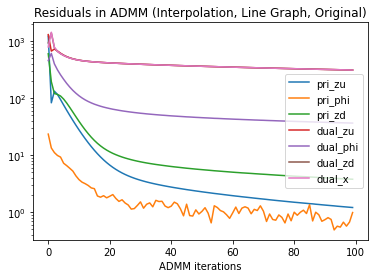

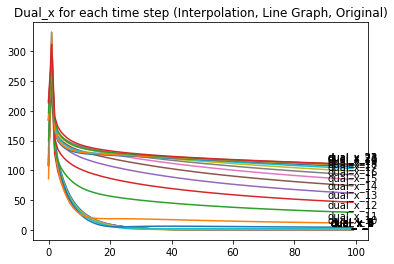

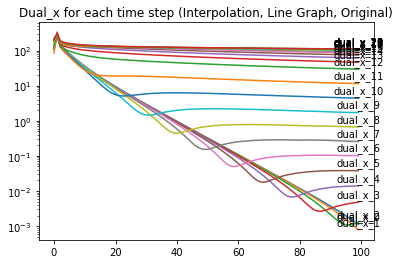

In [9]:
# line graph
import math
rho_init = math.sqrt(traffic_dataset.graph_info['n_nodes'] / 24)
mu_init = 1
print('rho_init:', rho_init)
ADMM_info = {
    'rho': rho_init * 2,
    'rho_u': rho_init * 3,
    'rho_d': rho_init * 2,
    'mu_u': mu_init,
    'mu_d1':mu_init * 2,
    'mu_d2': mu_init
}
admm_block = ADMM_algorithm(traffic_dataset.graph_info,
                            ADMM_info,
                            use_kNN=True,
                            k=4,
                            u_sigma=50,
                            d_sigma=50,
                            use_line_graph=True
                            )
x_interp = admm_block.combined_loop(interp_y, mask=mask)
admm_block.plot_residual(descriptions='Interpolation, Line Graph, Original', log_y=True)
admm_block.plot_x_per_step(descriptions='Interpolation, Line Graph, Original', log_y=False)
admm_block.plot_x_per_step(descriptions='Interpolation, Line Graph, Original', log_y=True)

## 3.3 Ablation Studies

### 3.3.1 Undirected graphs
- with **line graph**
- with **kNN graph**

rho_init: 3.5765439556458225
307 nodes, 4 neighbors
Undirected graph: sigma = 50, nearest_dist in (3.2000, 2895.6001)
u_ew, d_ew shape torch.Size([24, 307, 4]) torch.Size([23, 307, 1])
Linear regression: w torch.Size([1, 307, 1]), b torch.Size([1, 307, 1])
ADMM iters 0: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 17, pri_err = [1217, 644.2], dual_err = [1354, 963.5]
ADMM iters 1: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 16, pri_err = [117.1, 210.1], dual_err = [779.7, 1402]
ADMM iters 2: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 16, pri_err = [135, 173.4], dual_err = [749.7, 787.5]
ADMM iters 3: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 16, pri_err = [114, 137.6], dual_err = [674.6, 670.5]
ADMM iters 4: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 16, pri_err = [91.31, 101.8], dual_err = [611.4, 606.7]
ADMM iters 5: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 16, pri_err = [73.13, 72.97], dual_err = [565.6, 562]
ADMM iters 6: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 16, pri_err = [58.99, 52

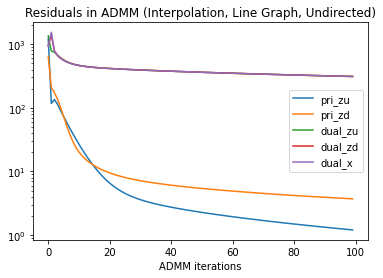

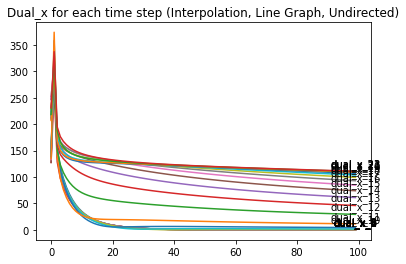

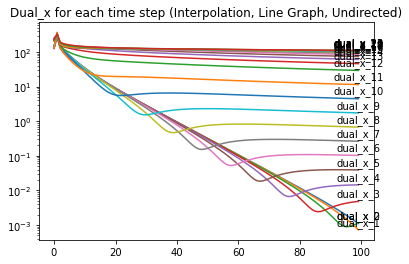

In [10]:
import math
rho_init = math.sqrt(traffic_dataset.graph_info['n_nodes'] / 24)
mu_init = 1
print('rho_init:', rho_init)
ADMM_info = {
    'rho': rho_init * 2,
    'rho_u': rho_init * 3,
    'rho_d': rho_init * 2,
    'mu_u': mu_init,
    'mu_d1':mu_init * 2,
    'mu_d2': mu_init
}
admm_block = ADMM_algorithm(traffic_dataset.graph_info,
                            ADMM_info,
                            use_kNN=True,
                            k=4,
                            u_sigma=50,
                            d_sigma=50,
                            use_line_graph=True,
                            ablation='UT'
                            )
x_interp = admm_block.combined_loop(interp_y, mask=mask)
admm_block.plot_residual(descriptions='Interpolation, Line Graph, Undirected', log_y=True)
admm_block.plot_x_per_step(descriptions='Interpolation, Line Graph, Undirected', log_y=False)
admm_block.plot_x_per_step(descriptions='Interpolation, Line Graph, Undirected', log_y=True)

rho_init: 3.5765439556458225
307 nodes, 4 neighbors
Undirected graph: sigma = 50, nearest_dist in (3.2000, 2895.6001)
Directed Graph: sigma = 50, nearest_dist in (3.2000, 2895.6001)
u_ew, d_ew shape torch.Size([24, 307, 4]) torch.Size([23, 307, 5])
Linear regression: w torch.Size([1, 307, 1]), b torch.Size([1, 307, 1])
ADMM iters 0: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 17, pri_err = [1217, 644.2], dual_err = [1354, 960.3]
ADMM iters 1: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 16, pri_err = [117.4, 209.5], dual_err = [780.4, 1393]
ADMM iters 2: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 16, pri_err = [135.6, 171.9], dual_err = [750.7, 788.8]
ADMM iters 3: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 16, pri_err = [114.4, 136.4], dual_err = [675.2, 671.4]
ADMM iters 4: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 16, pri_err = [91.49, 101.1], dual_err = [611.6, 607.1]
ADMM iters 5: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 16, pri_err = [73.15, 72.66], dual_err = [565.7, 562.1]
ADMM iters

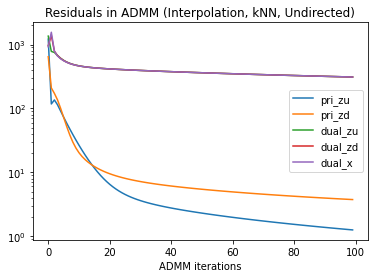

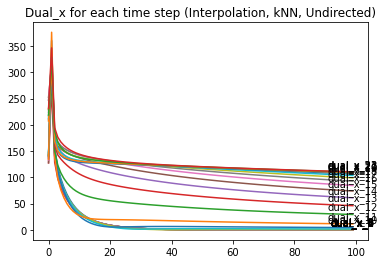

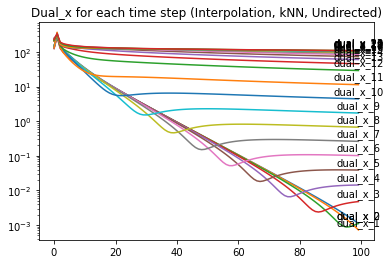

In [11]:
import math
rho_init = math.sqrt(traffic_dataset.graph_info['n_nodes'] / 24)
mu_init = 1
print('rho_init:', rho_init)
ADMM_info = {
    'rho': rho_init * 2,
    'rho_u': rho_init * 3,
    'rho_d': rho_init * 2,
    'mu_u': mu_init,
    'mu_d1':mu_init * 2,
    'mu_d2': mu_init
}
admm_block = ADMM_algorithm(traffic_dataset.graph_info,
                            ADMM_info,
                            use_kNN=True,
                            k=4,
                            u_sigma=50,
                            d_sigma=50,
                            use_line_graph=False,
                            ablation='UT'
                            )
x_interp = admm_block.combined_loop(interp_y, mask=mask)
admm_block.plot_residual(descriptions='Interpolation, kNN, Undirected', log_y=True)
admm_block.plot_x_per_step(descriptions='Interpolation, kNN, Undirected', log_y=False)
admm_block.plot_x_per_step(descriptions='Interpolation, kNN, Undirected', log_y=True)

rho_init: 3.5765439556458225
307 nodes, 4 neighbors
Undirected graph: sigma = 50, nearest_dist in (3.2000, 2895.6001)
u_ew, d_ew shape torch.Size([24, 307, 4]) torch.Size([23, 307, 1])
ADMM iters 0: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 16, pri_err = [1696, 345.9], dual_err = [1696, 345.9]
ADMM iters 1: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 16, pri_err = [80.61, 38.72], dual_err = [339.9, 1985]
ADMM iters 2: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 15, pri_err = [206.2, 49.86], dual_err = [768.9, 893.1]
ADMM iters 3: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 15, pri_err = [187.6, 48.68], dual_err = [707, 691.4]
ADMM iters 4: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 15, pri_err = [157.8, 38.45], dual_err = [614.2, 590.4]
ADMM iters 5: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 15, pri_err = [132, 28.03], dual_err = [533.7, 513.5]
ADMM iters 6: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 15, pri_err = [110.8, 20], dual_err = [466.7, 450.3]
ADMM iters 7: x_CG_iters 2, zu_CG_iters 1

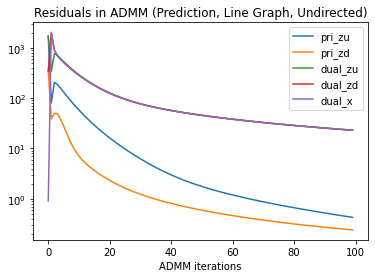

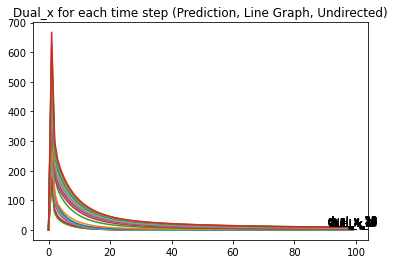

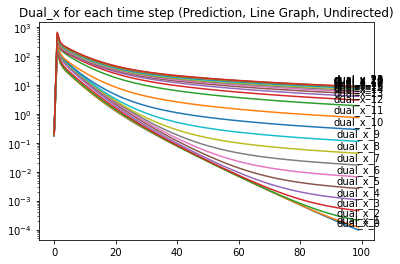

In [15]:
import math
rho_init = math.sqrt(traffic_dataset.graph_info['n_nodes'] / 24)
mu_init = 1
print('rho_init:', rho_init)
ADMM_info = {
    'rho': rho_init * 2,
    'rho_u': rho_init * 3,
    'rho_d': rho_init * 2,
    'mu_u': mu_init,
    'mu_d1':mu_init * 2,
    'mu_d2': mu_init
}
admm_block = ADMM_algorithm(traffic_dataset.graph_info,
                            ADMM_info,
                            use_kNN=True,
                            k=4,
                            u_sigma=50,
                            d_sigma=50,
                            use_line_graph=True,
                            ablation='UT'
                            )
x_pred = admm_block.combined_loop(y)
admm_block.plot_residual(descriptions='Prediction, Line Graph, Undirected', log_y=True)
admm_block.plot_x_per_step(descriptions='Prediction, Line Graph, Undirected', log_y=False)
admm_block.plot_x_per_step(descriptions='Prediction, Line Graph, Undirected', log_y=True)

rho_init: 3.5765439556458225
307 nodes, 4 neighbors
Undirected graph: sigma = 50, nearest_dist in (3.2000, 2895.6001)
Directed Graph: sigma = 50, nearest_dist in (3.2000, 2895.6001)
u_ew, d_ew shape torch.Size([24, 307, 4]) torch.Size([23, 307, 5])
ADMM iters 0: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 16, pri_err = [1696, 371.1], dual_err = [1696, 371.1]
ADMM iters 1: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 16, pri_err = [89.95, 51.7], dual_err = [361.2, 1970]
ADMM iters 2: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 16, pri_err = [207.3, 53.39], dual_err = [771.6, 894.9]
ADMM iters 3: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 16, pri_err = [187.7, 50.48], dual_err = [707.6, 692.6]
ADMM iters 4: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 15, pri_err = [157.7, 39.88], dual_err = [613.9, 590.6]
ADMM iters 5: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 15, pri_err = [131.7, 29.34], dual_err = [532.9, 513.1]
ADMM iters 6: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 15, pri_err = [110.3, 21.21

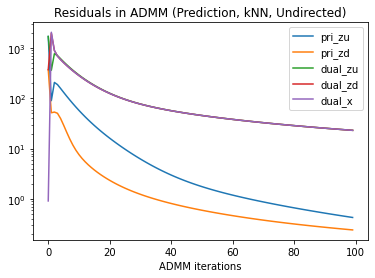

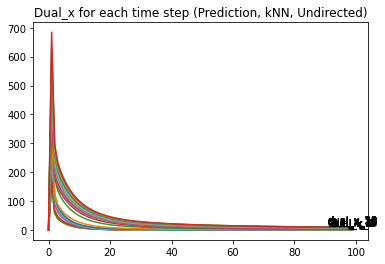

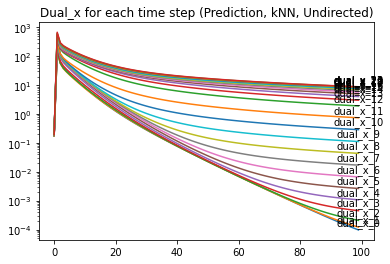

In [16]:
import math
rho_init = math.sqrt(traffic_dataset.graph_info['n_nodes'] / 24)
mu_init = 1
print('rho_init:', rho_init)
ADMM_info = {
    'rho': rho_init * 2,
    'rho_u': rho_init * 3,
    'rho_d': rho_init * 2,
    'mu_u': mu_init,
    'mu_d1':mu_init * 2,
    'mu_d2': mu_init
}
admm_block = ADMM_algorithm(traffic_dataset.graph_info,
                            ADMM_info,
                            use_kNN=True,
                            k=4,
                            u_sigma=50,
                            d_sigma=50,
                            use_line_graph=False,
                            ablation='UT'
                            )
x_pred = admm_block.combined_loop(y)
admm_block.plot_residual(descriptions='Prediction, kNN, Undirected', log_y=True)
admm_block.plot_x_per_step(descriptions='Prediction, kNN, Undirected', log_y=False)
admm_block.plot_x_per_step(descriptions='Prediction, kNN, Undirected', log_y=True)

### 3.3.2 w/o DGTV
Remove DGTV term for kNN graph and line graph

rho_init: 3.5765439556458225
307 nodes, 4 neighbors
Undirected graph: sigma = 50, nearest_dist in (3.2000, 2895.6001)
u_ew, d_ew shape torch.Size([24, 307, 4]) torch.Size([23, 307, 1])
Linear regression: w torch.Size([1, 307, 1]), b torch.Size([1, 307, 1])
ADMM iters 0: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 17, pri_err = [1217, 644.2], dual_err = [1354, 963.5]
ADMM iters 1: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 16, pri_err = [117.1, 210.1], dual_err = [779.7, 1402]
ADMM iters 2: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 16, pri_err = [135, 173.4], dual_err = [749.7, 787.5]
ADMM iters 3: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 16, pri_err = [114, 137.6], dual_err = [674.6, 670.5]
ADMM iters 4: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 16, pri_err = [91.31, 101.8], dual_err = [611.4, 606.7]
ADMM iters 5: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 16, pri_err = [73.13, 72.97], dual_err = [565.6, 562]
ADMM iters 6: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 16, pri_err = [58.99, 52

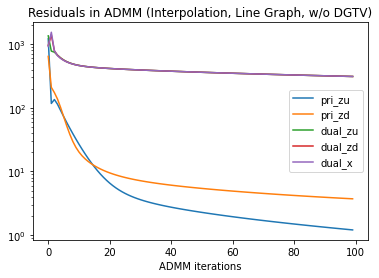

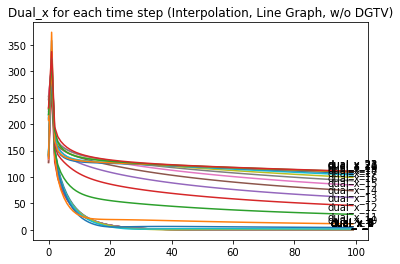

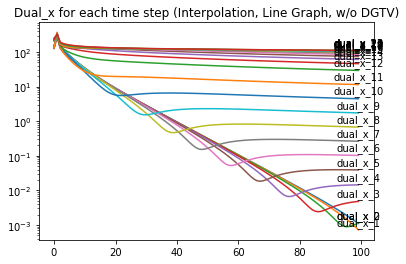

In [13]:
import math
rho_init = math.sqrt(traffic_dataset.graph_info['n_nodes'] / 24)
mu_init = 1
print('rho_init:', rho_init)
ADMM_info = {
    'rho': rho_init * 2,
    'rho_u': rho_init * 3,
    'rho_d': rho_init * 2,
    'mu_u': mu_init,
    'mu_d1':mu_init * 2,
    'mu_d2': mu_init
}
admm_block = ADMM_algorithm(traffic_dataset.graph_info,
                            ADMM_info,
                            use_kNN=True,
                            k=4,
                            u_sigma=50,
                            d_sigma=50,
                            use_line_graph=True,
                            ablation='DGTV'
                            )
x_interp = admm_block.combined_loop(interp_y, mask=mask)
admm_block.plot_residual(descriptions='Interpolation, Line Graph, w/o DGTV', log_y=True)
admm_block.plot_x_per_step(descriptions='Interpolation, Line Graph, w/o DGTV', log_y=False)
admm_block.plot_x_per_step(descriptions='Interpolation, Line Graph, w/o DGTV', log_y=True)

rho_init: 3.5765439556458225
307 nodes, 4 neighbors
Undirected graph: sigma = 50, nearest_dist in (3.2000, 2895.6001)
Directed Graph: sigma = 50, nearest_dist in (3.2000, 2895.6001)
u_ew, d_ew shape torch.Size([24, 307, 4]) torch.Size([23, 307, 5])
Linear regression: w torch.Size([1, 307, 1]), b torch.Size([1, 307, 1])
ADMM iters 0: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 17, pri_err = [1217, 644.2], dual_err = [1354, 960.3]
ADMM iters 1: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 16, pri_err = [117.4, 209.5], dual_err = [780.4, 1393]
ADMM iters 2: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 16, pri_err = [135.6, 171.9], dual_err = [750.7, 788.8]
ADMM iters 3: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 16, pri_err = [114.4, 136.4], dual_err = [675.2, 671.4]
ADMM iters 4: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 16, pri_err = [91.49, 101.1], dual_err = [611.6, 607.1]
ADMM iters 5: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 16, pri_err = [73.15, 72.66], dual_err = [565.7, 562.1]
ADMM iters

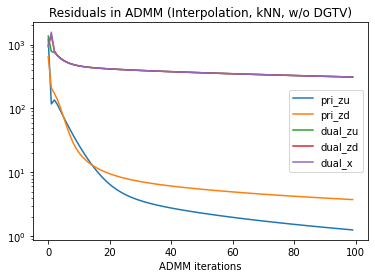

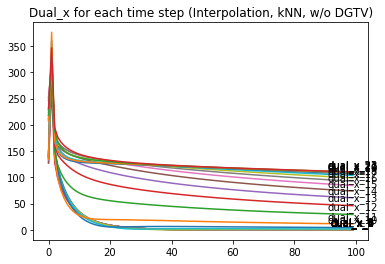

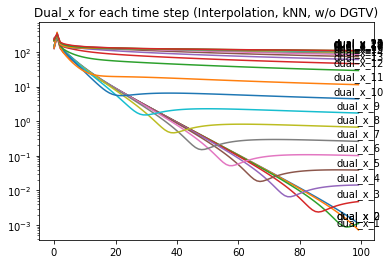

In [17]:
import math
rho_init = math.sqrt(traffic_dataset.graph_info['n_nodes'] / 24)
mu_init = 1
print('rho_init:', rho_init)
ADMM_info = {
    'rho': rho_init * 2,
    'rho_u': rho_init * 3,
    'rho_d': rho_init * 2,
    'mu_u': mu_init,
    'mu_d1':mu_init * 2,
    'mu_d2': mu_init
}
admm_block = ADMM_algorithm(traffic_dataset.graph_info,
                            ADMM_info,
                            use_kNN=True,
                            k=4,
                            u_sigma=50,
                            d_sigma=50,
                            use_line_graph=False,
                            ablation='DGTV'
                            )
x_interp = admm_block.combined_loop(interp_y, mask=mask)
admm_block.plot_residual(descriptions='Interpolation, kNN, w/o DGTV', log_y=True)
admm_block.plot_x_per_step(descriptions='Interpolation, kNN, w/o DGTV', log_y=False)
admm_block.plot_x_per_step(descriptions='Interpolation, kNN, w/o DGTV', log_y=True)

rho_init: 3.5765439556458225
307 nodes, 4 neighbors
Undirected graph: sigma = 50, nearest_dist in (3.2000, 2895.6001)
u_ew, d_ew shape torch.Size([24, 307, 4]) torch.Size([23, 307, 1])
ADMM iters 0: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 16, pri_err = [1696, 345.9], dual_err = [1696, 345.9]
ADMM iters 1: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 16, pri_err = [80.61, 38.72], dual_err = [339.9, 1985]
ADMM iters 2: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 15, pri_err = [206.2, 49.86], dual_err = [768.9, 893.1]
ADMM iters 3: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 15, pri_err = [187.6, 48.68], dual_err = [707, 691.4]
ADMM iters 4: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 15, pri_err = [157.8, 38.45], dual_err = [614.2, 590.4]
ADMM iters 5: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 15, pri_err = [132, 28.03], dual_err = [533.7, 513.5]
ADMM iters 6: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 15, pri_err = [110.8, 20], dual_err = [466.7, 450.3]
ADMM iters 7: x_CG_iters 2, zu_CG_iters 1

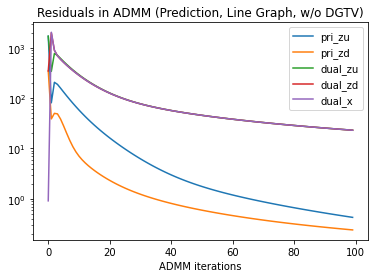

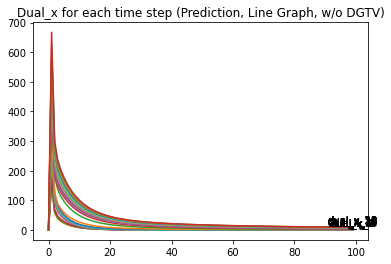

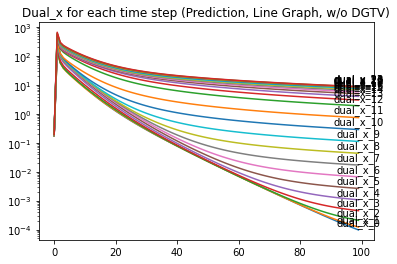

In [18]:
import math
rho_init = math.sqrt(traffic_dataset.graph_info['n_nodes'] / 24)
mu_init = 1
print('rho_init:', rho_init)
ADMM_info = {
    'rho': rho_init * 2,
    'rho_u': rho_init * 3,
    'rho_d': rho_init * 2,
    'mu_u': mu_init,
    'mu_d1':mu_init * 2,
    'mu_d2': mu_init
}
admm_block = ADMM_algorithm(traffic_dataset.graph_info,
                            ADMM_info,
                            use_kNN=True,
                            k=4,
                            u_sigma=50,
                            d_sigma=50,
                            use_line_graph=True,
                            ablation='DGTV'
                            )
x_pred = admm_block.combined_loop(y)
admm_block.plot_residual(descriptions='Prediction, Line Graph, w/o DGTV', log_y=True)
admm_block.plot_x_per_step(descriptions='Prediction, Line Graph, w/o DGTV', log_y=False)
admm_block.plot_x_per_step(descriptions='Prediction, Line Graph, w/o DGTV', log_y=True)

rho_init: 3.5765439556458225
307 nodes, 4 neighbors
Undirected graph: sigma = 50, nearest_dist in (3.2000, 2895.6001)
Directed Graph: sigma = 50, nearest_dist in (3.2000, 2895.6001)
u_ew, d_ew shape torch.Size([24, 307, 4]) torch.Size([23, 307, 5])
ADMM iters 0: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 16, pri_err = [1696, 371.1], dual_err = [1696, 371.1]
ADMM iters 1: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 16, pri_err = [89.95, 51.7], dual_err = [361.2, 1970]
ADMM iters 2: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 16, pri_err = [207.3, 53.39], dual_err = [771.6, 894.9]
ADMM iters 3: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 16, pri_err = [187.7, 50.48], dual_err = [707.6, 692.6]
ADMM iters 4: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 15, pri_err = [157.7, 39.88], dual_err = [613.9, 590.6]
ADMM iters 5: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 15, pri_err = [131.7, 29.34], dual_err = [532.9, 513.1]
ADMM iters 6: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 15, pri_err = [110.3, 21.21

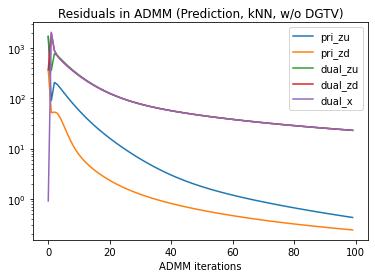

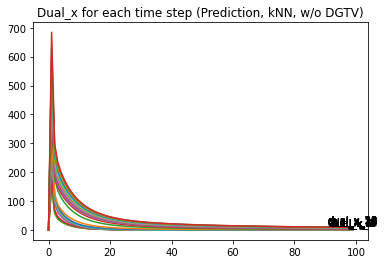

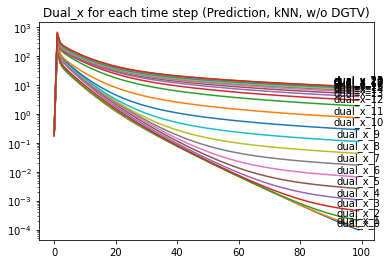

In [19]:
import math
rho_init = math.sqrt(traffic_dataset.graph_info['n_nodes'] / 24)
mu_init = 1
print('rho_init:', rho_init)
ADMM_info = {
    'rho': rho_init * 2,
    'rho_u': rho_init * 3,
    'rho_d': rho_init * 2,
    'mu_u': mu_init,
    'mu_d1':mu_init * 2,
    'mu_d2': mu_init
}
admm_block = ADMM_algorithm(traffic_dataset.graph_info,
                            ADMM_info,
                            use_kNN=True,
                            k=4,
                            u_sigma=50,
                            d_sigma=50,
                            use_line_graph=False,
                            ablation='DGTV'
                            )
x_pred = admm_block.combined_loop(y)
admm_block.plot_residual(descriptions='Prediction, kNN, w/o DGTV', log_y=True)
admm_block.plot_x_per_step(descriptions='Prediction, kNN, w/o DGTV', log_y=False)
admm_block.plot_x_per_step(descriptions='Prediction, kNN, w/o DGTV', log_y=True)